# Brand Inbound Delivery & Receiving Capacity Forecast

## Executive Summary

Inbound warehouse workload is driven by brand delivery plans, but actual shipped volumes consistently under-realize planned quantities.

This project forecasts inbound receiving volumes by:
1. Forecasting planned delivery quantities
2. Estimating realized shipments using historical shipment-to-plan ratios
3. Estimating the studio outbound operation capacity in line with the inbounded number of products.

The resulting forecasts support **receiving capacity, dock scheduling, and storage planning** under high uncertainty.

### Setup

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pathlib, warnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing

warnings.filterwarnings('ignore')

In [2]:
path = str(pathlib.Path().absolute())

In [3]:
def planned_weekly(week, planned):
    total = planned.loc[(planned['del_planned_open'] <= week['Week_Starting']) & (planned['del_planned_close'] >= week['Week_Ending'])]['planned_qty'].sum()
    return total

In [4]:
def wape(y, yhat):
    return np.sum(np.abs(y - yhat)) / np.sum(np.abs(y))

In [5]:
def to_index_with_base(s, base_value, base=100):
    s = s.astype(float).copy()
    return (s / base_value) * base

### Import Data

In [6]:
delivery_df = pd.read_excel(path[:-9] + '\\data\\pbi_direct_query.xlsx', sheet_name = 'delivery_qty', skiprows=2, parse_dates=['16_MOMA[operation_date]'])
delivery_df.rename(columns={'16_MOMA[operation_date]':'del_date', '[Sumtotal_shipped_quantity]':'shipped_qty'}, inplace=True)
delivery_df = delivery_df.set_index('del_date')['shipped_qty'].resample('W-FRI').sum().asfreq('W-FRI', fill_value=0).reset_index().rename(columns={'del_date':'Week_Ending'})

In [7]:
df_planned = pd.read_excel(path[:-9] + '\\data\\pbi_direct_query.xlsx', sheet_name = 'del_window_qty', skiprows=2, parse_dates=['12_PO export[del_window_open]', '12_PO export[del_window_close]', 'mid_day'])
df_planned.rename(columns={'12_PO export[del_window_open]':'del_planned_open', '12_PO export[del_window_close]':'del_planned_close', 'qty':'planned_qty', 'Sumunits':'sum_unit'}, inplace=True)

del_planned_open = df_planned.set_index('del_planned_open')['planned_qty'].resample('W-FRI').sum().asfreq('W-FRI', fill_value=0).rename('planned_open_qty').reset_index().rename(columns={'del_planned_open':'Week_Ending'})
del_planned_close = df_planned.set_index('del_planned_close')['planned_qty'].resample('W-FRI').sum().asfreq('W-FRI', fill_value=0).rename('planned_close_qty').reset_index().rename(columns={'del_planned_close':'Week_Ending'})

In [8]:
planned = del_planned_open.merge(del_planned_close, how='outer', on='Week_Ending').fillna(0)
all_delivery_df = delivery_df.merge(planned, how='outer', on='Week_Ending').fillna(0)

all_delivery_df = all_delivery_df.loc[(all_delivery_df['Week_Ending'] >= '2024-01-01') & (all_delivery_df['Week_Ending'] <= str(dt.date.today()))].reset_index(drop=True)

In [9]:
df = all_delivery_df[['Week_Ending']].copy()
df['Week_Starting'] = df['Week_Ending'] - pd.to_timedelta(6, unit='d')
df['planned_weekly'] = df.apply(lambda x: planned_weekly(x, df_planned), axis=1)

In [10]:
all_delivery_df = all_delivery_df.merge(df[['Week_Ending', 'planned_weekly']], how='left', on='Week_Ending')
all_delivery_df.drop(columns=['planned_open_qty', 'planned_close_qty'], inplace=True)
all_delivery_df['planned_weekly'] = all_delivery_df['planned_weekly'].fillna(0)
all_delivery_df['percentage'] = round(all_delivery_df['shipped_qty'] / all_delivery_df['planned_weekly'], 2)

## Forecasting Planned Delivery

In [11]:
fc_planned = all_delivery_df.set_index('Week_Ending')['planned_weekly']
fc_planned = fc_planned.asfreq('W-FRI', fill_value=0)
fc_planned = fc_planned.sort_index()

In [12]:
h = 8 # test set of 8 weeks (2 months)
train = fc_planned[:-h]
test = fc_planned[-h:]

In [13]:
hw_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=26, damped_trend=False).fit(use_brute=True)
fc_hw = hw_model.forecast(h)

hw_model.mle_retvals

# Model incompatible, try scaling approach!

 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 646280004.6385897
       x: [ 7.121e-01  2.967e-02 ...  3.340e+03  3.818e+03]
     nit: 1
     jac: [-4.635e+06  1.666e+08 ... -3.008e+03 -3.440e+02]
    nfev: 32
    njev: 1

In [14]:
scale = train.mean()
train_s = train / scale

model = ExponentialSmoothing(train_s, trend='add', seasonal='add', seasonal_periods=26, damped_trend=True).fit()
fc = model.forecast(h) * scale
model.mle_retvals

# Successful model, proceed to final forecast

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.44206694715921724
       x: [ 6.467e-01  5.330e-18 ...  9.906e-02  1.152e-01]
     nit: 23
     jac: [-2.737e-04  1.202e-01 ... -1.768e-04 -8.369e-04]
    nfev: 785
    njev: 23

In [15]:
metrics_hw = {
    "MAE": np.mean(np.abs(test - fc)),
    "RMSE": np.sqrt(np.mean((test - fc)**2)),
    "WAPE": wape(test, fc),
    "Bias": np.mean(fc - test)
}
metrics_hw

# Metrics not ideal, but acceptable for business use case. Will monitor and update model as needed.

{'MAE': 6696.519938681167,
 'RMSE': 8573.09458863081,
 'WAPE': 0.25660851419959446,
 'Bias': 6696.519938681167}

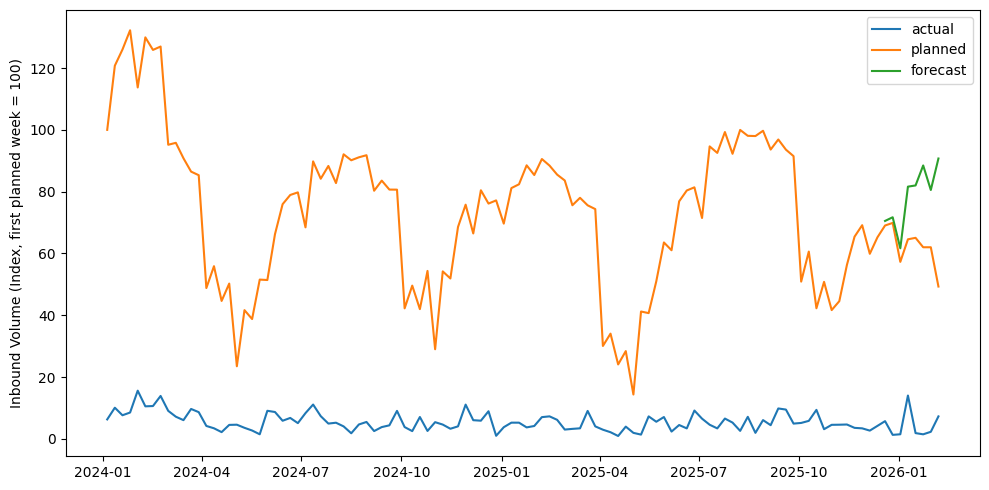

In [16]:
base_val = all_delivery_df.planned_weekly.replace(0, np.nan).dropna().iloc[0]

actual_idx = to_index_with_base(all_delivery_df.set_index("Week_Ending")["shipped_qty"], base_val)
planned_idx = to_index_with_base(all_delivery_df.set_index("Week_Ending")["planned_weekly"], base_val)
fc_idx = to_index_with_base(fc, base_val)

plt.figure(figsize=(10,5))
plt.plot(actual_idx.index, actual_idx, label ='actual')
plt.plot(planned_idx.index, planned_idx, label='planned')
plt.plot(fc_idx.index, fc_idx, label='forecast')
plt.ylabel("Inbound Volume (Index, first planned week = 100)")
plt.legend()

plt.tight_layout()
plt.show()

### Final Model

Scaled exponantial smoothing

In [17]:
scale = fc_planned.mean()
scaled = fc_planned / scale

# Removing last h weeks for model compatibility, will forecast (h*3) to ensure we have 16 weeks of forecast.
final_model = ExponentialSmoothing(scaled[:-h], trend='add', seasonal='add', seasonal_periods=26, damped_trend=False).fit(use_brute=True)
final_hw = final_model.forecast(h*3) * scale

final_model.mle_retvals

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.4645877104871468
       x: [ 6.914e-01  2.982e-17 ...  1.062e-01  1.247e-01]
     nit: 23
     jac: [-3.304e-04  3.212e-01 ... -1.364e-03 -7.048e-04]
    nfev: 761
    njev: 23

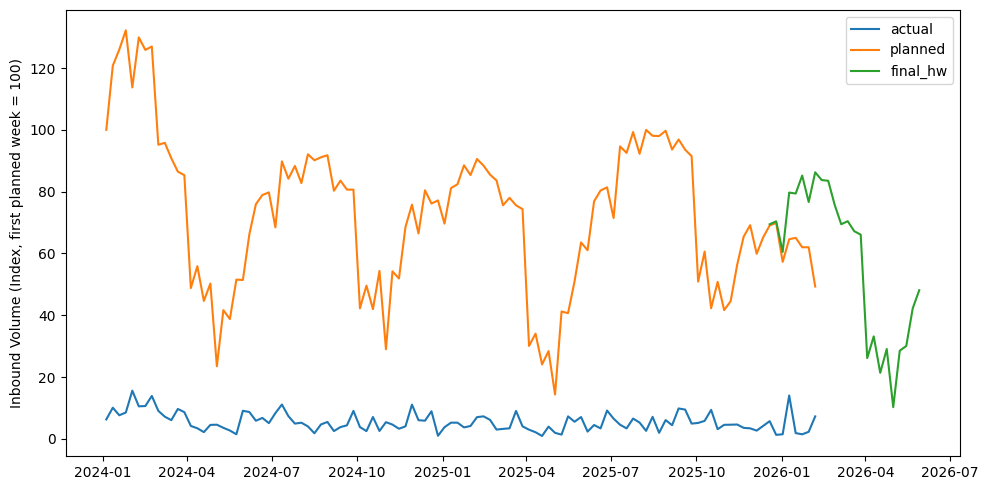

In [18]:
base_val = all_delivery_df.planned_weekly.replace(0, np.nan).dropna().iloc[0]

actual_idx = to_index_with_base(all_delivery_df.set_index("Week_Ending")["shipped_qty"], base_val)
planned_idx = to_index_with_base(all_delivery_df.set_index("Week_Ending")["planned_weekly"], base_val)
final_hw_idx = to_index_with_base(final_hw, base_val)

plt.figure(figsize=(10,5))
plt.plot(actual_idx.index, actual_idx, label ='actual')
plt.plot(planned_idx.index, planned_idx, label='planned')
plt.plot(final_hw_idx.index, final_hw_idx, label='final_hw')

plt.ylabel("Inbound Volume (Index, first planned week = 100)")
plt.legend()

plt.tight_layout()
plt.show()

## Forecasting Delivery Ratio

In [19]:
ratio_df = all_delivery_df[['Week_Ending', 'percentage']].copy()[:-h]
print(min(ratio_df['percentage']), max(ratio_df['percentage']))

0.01 0.22


In [20]:
r_hat = ratio_df["percentage"].median()
print(r_hat)

shipped_fc = final_hw * r_hat

0.07


In [21]:
df = pd.merge(all_delivery_df[['Week_Ending', 'shipped_qty', 'planned_weekly']], 
              pd.DataFrame({'Week_Ending': final_hw.index, 'final_hw': final_hw.values, 'shipped_fc': shipped_fc.values}), 
              how='outer', on='Week_Ending')

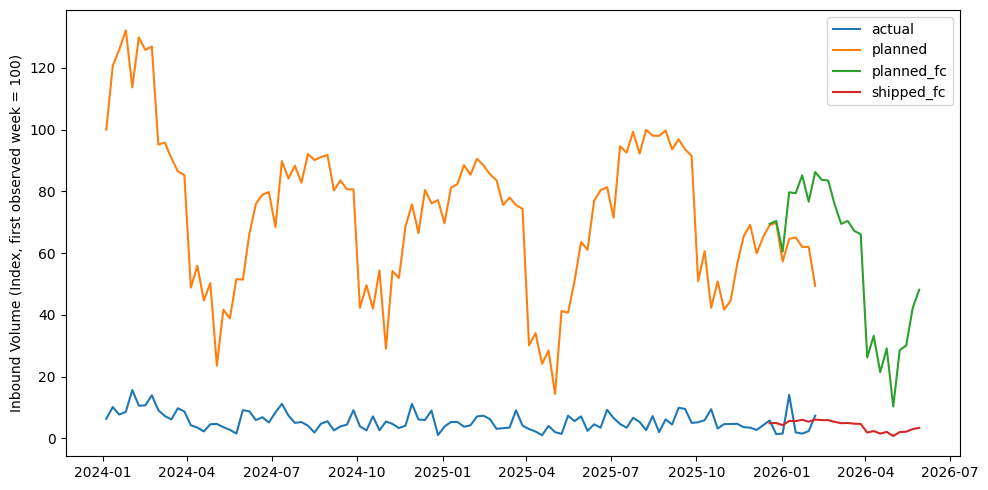

In [22]:
base_val = all_delivery_df.planned_weekly.replace(0, np.nan).dropna().iloc[0]

actual_idx = to_index_with_base(df.set_index("Week_Ending")["shipped_qty"], base_val)
planned_idx = to_index_with_base(df.set_index("Week_Ending")["planned_weekly"], base_val)
final_hw_idx = to_index_with_base(df.set_index("Week_Ending")["final_hw"], base_val)
shipped_fc_idx = to_index_with_base(df.set_index("Week_Ending")["shipped_fc"], base_val)

plt.figure(figsize=(10,5))
plt.plot(actual_idx.index, actual_idx, label ='actual')
plt.plot(planned_idx.index, planned_idx, label='planned')
plt.plot(final_hw_idx.index, final_hw_idx, label='planned_fc')
plt.plot(shipped_fc_idx.index, shipped_fc_idx, label='shipped_fc')

plt.ylabel("Inbound Volume (Index, first observed week = 100)")
plt.legend()

plt.tight_layout()
plt.show()

## Studio Outbound

In [23]:
b2b = pd.read_csv(path[:-9] + '\\data\\london_studio_deliveries.csv', parse_dates=['operation_date'])
b2b = b2b.set_index('operation_date')['shipped_quantity'].resample('W-FRI').sum().asfreq('W-FRI', fill_value=0).rename('b2b_shipped').reset_index().rename(columns={'operation_date':'Week_Ending'})
df = df.merge(b2b, how='left', on='Week_Ending')
df['b2b_percentage'] = round(df['b2b_shipped'] / df['shipped_qty'], 2).fillna(0)

In [24]:
mean_b2b = df['b2b_percentage'].mean()
mean_b2b

0.0680952380952381

In [25]:
df['b2b_fc'] = round(df['shipped_fc']*mean_b2b/5, 0)*5

## Export File

In [26]:
df_export = df.copy().drop(columns=['b2b_shipped', 'b2b_percentage'])
df_export['final_hw'] = round(df_export['final_hw'].where(df_export['final_hw'].notna()), -1)
df_export['shipped_fc'] = round(df_export['shipped_fc'].where(df_export['shipped_fc'].notna()), -1)
df_export.to_excel(f'{path[:-9]}\\data\\{dt.date.today()}_delivery_forecast.xlsx', index=False)

## Operational Interpretation

- Planned delivery quantities represent an upper bound, not expected workload
- A stable historical shipment-to-plan ratio (~7%) provides a robust adjustment factor
- Receiving capacity should be planned using **ranges**, not point estimates
- Forecasts should be refreshed weekly as delivery windows evolve